# Supervised Machine Learning: Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
diamonds = sns.load_dataset('diamonds')

diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**What the columns of our DataFrame mean**
* price: price in US dollars (\$326–\$18,823)
* carat: weight of the diamond (0.2–5.01)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond colour, from D (best) to J (worst)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x: length in mm (0–10.74)
* y: width in mm (0–58.9)
* z: depth in mm (0–31.8)
* depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79)
* table: width of top of diamond relative to widest point (43–95)

In [ ]:
X = diamonds.copy()
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96


## Dummy model

Normally the price of a diamond is linked to how many carats. So first, let's look at the price and the carats of a diamond to see if we can make a quick dumb model.

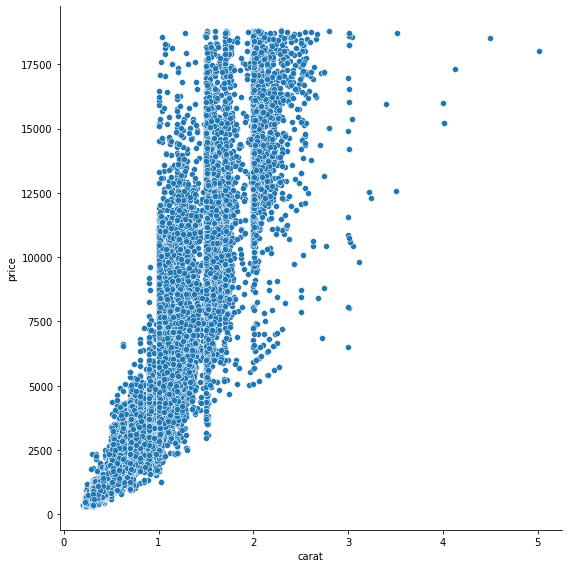

In [ ]:
sns.relplot(x = X_train['carat'], y = y_train, height = 8);

Based on the graph above I'm going to create a real simple model:

$$
price = carat*6000
$$

In [ ]:
dumb_model_df = diamonds.copy()
dumb_model_df["predicted_price"] = dumb_model_df["carat"] * 6000
dumb_model_df["price_difference"] = dumb_model_df["predicted_price"] - dumb_model_df["price"]

dumb_model_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,predicted_price,price_difference
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,1380.0,1054.0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1260.0,934.0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,1380.0,1053.0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,1740.0,1406.0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,1860.0,1525.0


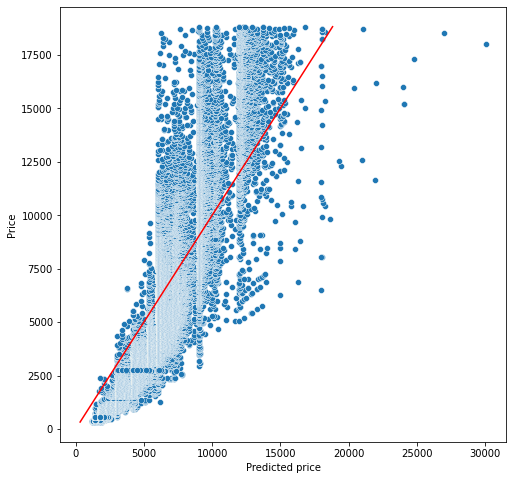

In [ ]:
def plot_predictions(y_true, y_pred): 
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min(y_true.tolist())])
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Price')
    plt.xlabel('Predicted price')
    plt.show()

plot_predictions(dumb_model_df['price'], dumb_model_df['predicted_price'])

### Results
[List of what metrics are available](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics)

[Explanation of all regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

#### Mean Absolute Error
It's the average difference between the actual values and the predicted value.

In [ ]:
from sklearn.metrics import mean_absolute_error

dumb_mae = mean_absolute_error(y_true = dumb_model_df["price"], y_pred = dumb_model_df['predicted_price'])
dumb_mae

1641.5419911012236

#### Mean Squared Error
Each error is squared before the mean is calculated. This means the outliers affect this number more.

In [ ]:
from sklearn.metrics import mean_squared_error

dumb_mse = mean_squared_error(y_true = dumb_model_df["price"], y_pred = dumb_model_df['predicted_price'])
dumb_mse

3821856.8139228774

#### Root Mean Squared Error
A square root version of the above number. Taking the square root makes the number more relatable to our actual prices

In [ ]:
dumb_rmse = mean_squared_error(y_true = dumb_model_df["price"], y_pred = dumb_model_df['predicted_price'], squared=False)
dumb_rmse

1954.956985184809

#### Mean Absolute Percentage
Calculates the difference between the real price and the predicted price as a percentage, then takes an average of these percentages. The output is the relative percentage error.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

dumb_mape = mean_absolute_percentage_error(y_true = dumb_model_df["price"], y_pred = dumb_model_df['predicted_price'])
dumb_mape

0.9335744774820053

#### R-squared
Best possible score is 1.0, predicting every variable correctly. A constant model that always predicts the expected (average) value of y, disregarding the input features, would get an score of 0.0. R-squared is a little more technical than this, if you're into maths please read more [here](https://statisticsbyjim.com/regression/interpret-r-squared-regression/).

In [ ]:
from sklearn.metrics import r2_score

dumb_r2 = r2_score(y_true = dumb_model_df["price"], y_pred = dumb_model_df['predicted_price'])

## Creating our 1st model

In [ ]:
X = diamonds.copy()
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

X_cat = X_train.select_dtypes(exclude = 'number').columns
X_num = X_train.select_dtypes(include = 'number').columns

cut = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color = ['D','E','F','G','H','I','J']
clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

preprocessor = ColumnTransformer(transformers=[
    ('category', OrdinalEncoder(categories=[cut, color, clarity]), X_cat),
    ('number', "passthrough", X_num) 
])

In [ ]:
dt_pipeline = make_pipeline(preprocessor, 
                            StandardScaler(),
                            DecisionTreeRegressor())

dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                               

In [ ]:
dt_predictions = dt_pipeline.predict(X_test)

### How well is my model performing?

In [ ]:
dt_mae = mean_absolute_error(y_true = y_test, y_pred = dt_predictions)
dt_rmse = mean_squared_error(y_true = y_test, y_pred = dt_predictions, squared=False)
dt_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = dt_predictions)
dt_r2 = r2_score(y_true = y_test, y_pred = dt_predictions)

In [ ]:
pd.DataFrame({"MAE": [dumb_mae, dt_mae],
              "RMSE": [dumb_rmse, dt_rmse],
              "MAPE": [dumb_mape, dt_mape],
              "R2": [dumb_r2, dt_r2]},
             index=["dumb_model", "decision_tree"])

,MAE,RMSE,MAPE,R2
dumb_model,1641.541991,1954.956985,0.933574,0.759863
decision_tree,358.976394,749.004135,0.084023,0.965136


## Trying different models
[SKLearn guide for models](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_pipeline = make_pipeline(preprocessor, 
                            StandardScaler(),
                            SGDRegressor())

sgd_pipeline.fit(X_train, y_train)

sgd_predictions = sgd_pipeline.predict(X_test)

sgd_mae = mean_absolute_error(y_true = y_test, y_pred = sgd_predictions)
sgd_rmse = mean_squared_error(y_true = y_test, y_pred = sgd_predictions, squared=False)
sgd_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = sgd_predictions)
sgd_r2 = r2_score(y_true = y_test, y_pred = sgd_predictions)

In [ ]:
from sklearn.linear_model import LinearRegression

lr_pipeline = make_pipeline(preprocessor, 
                            StandardScaler(),
                            LinearRegression())

lr_pipeline.fit(X_train, y_train)

lr_predictions = lr_pipeline.predict(X_test)

lr_mae = mean_absolute_error(y_true = y_test, y_pred = lr_predictions)
lr_rmse = mean_squared_error(y_true = y_test, y_pred = lr_predictions, squared=False)
lr_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = lr_predictions)
lr_r2 = r2_score(y_true = y_test, y_pred = lr_predictions)

In [ ]:
comparing_models_df = pd.DataFrame({"MAE": [dumb_mae, dt_mae, sgd_mae, lr_mae],
                                    "RMSE": [dumb_rmse, dt_rmse, sgd_rmse, lr_rmse],
                                    "MAPE": [dumb_mape, dt_mape, sgd_mape, lr_mape],
                                    "R2": [dumb_r2, dt_r2, sgd_r2, lr_r2]},
                                    index=["dumb_model", "decision_tree", "sgd", "linear_regression"])

comparing_models_df

,MAE,RMSE,MAPE,R2
dumb_model,1641.541991,1954.956985,0.933574,0.759863
decision_tree,358.976394,749.004135,0.084023,0.965136
sgd,817.494243,1207.896182,0.449170,0.909329
linear_regression,809.435712,1205.942559,0.437738,0.909622


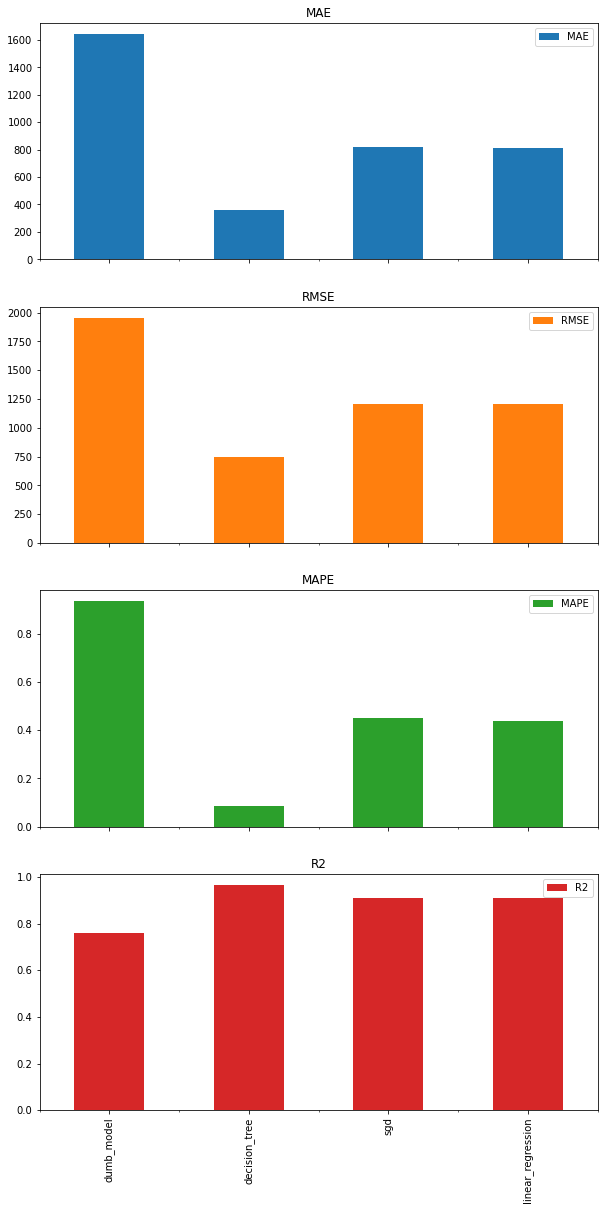

In [ ]:
comparing_models_df.plot.bar(subplots=True, figsize=(10, 20));

You should choose your metric before modelling your data. But we've shown all 4 side by side here to help give you a comprehension of their similarities and differences.

## Other ways of viewing our models

### Histogram of errors

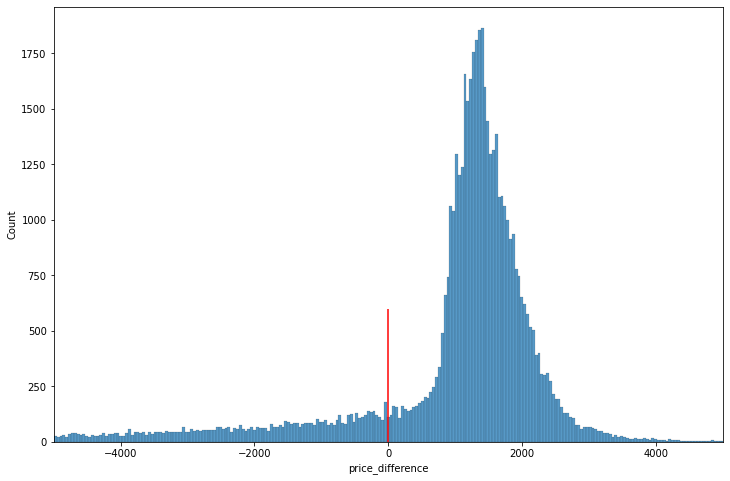

In [ ]:
plt.subplots(figsize=(12, 8))
sns.histplot(dumb_model_df["price_difference"])
plt.vlines(x=0, ymin=0, ymax=600, color='red')
plt.xlim(-5000, 5000)
plt.show()

Most of the predictions for our dumb model are positive (left skew). This tells us that in general our model tends to overpredict the price of the diamond.

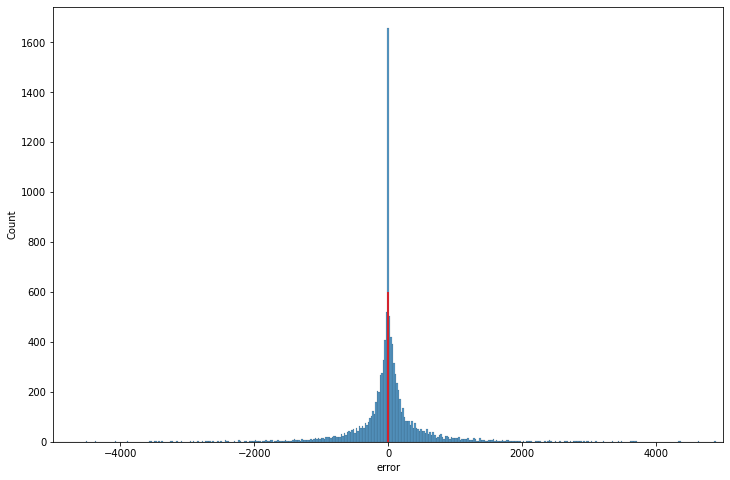

In [ ]:
dt_errors_df = X_test.copy()
dt_errors_df["price"] = y_test
dt_errors_df["prediction"] = dt_predictions
dt_errors_df["error"] = dt_errors_df["prediction"] - dt_errors_df["price"]

plt.subplots(figsize=(12, 8))
sns.histplot(dt_errors_df['error'])
plt.vlines(x=0, ymin=0, ymax=600, color='red')
plt.xlim(-5000, 5000)
plt.show()

We can see from our decision tree model that it is much more even handed in its over- and underestimation of the price

### Scatterplot of errors

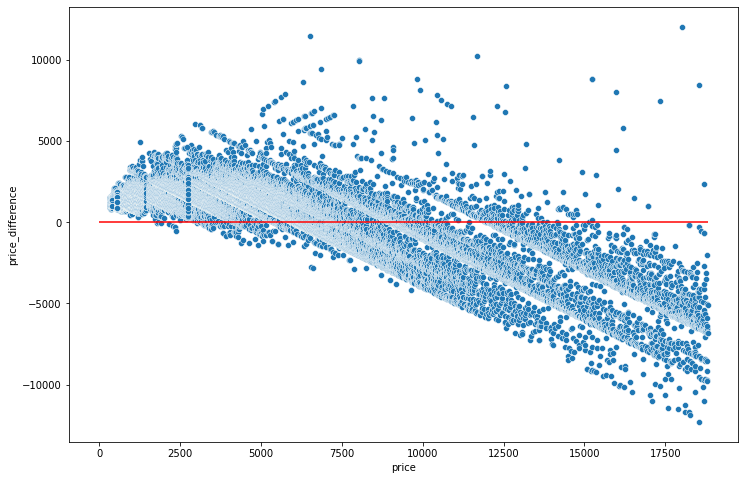

In [ ]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(data=dumb_model_df, x='price', y='price_difference')
plt.hlines(y=0, xmin=0, xmax=max(dumb_model_df['price']), color='red')
plt.show()

We can see that the more expensive the diamonds become, the worse our model is at predicting the price

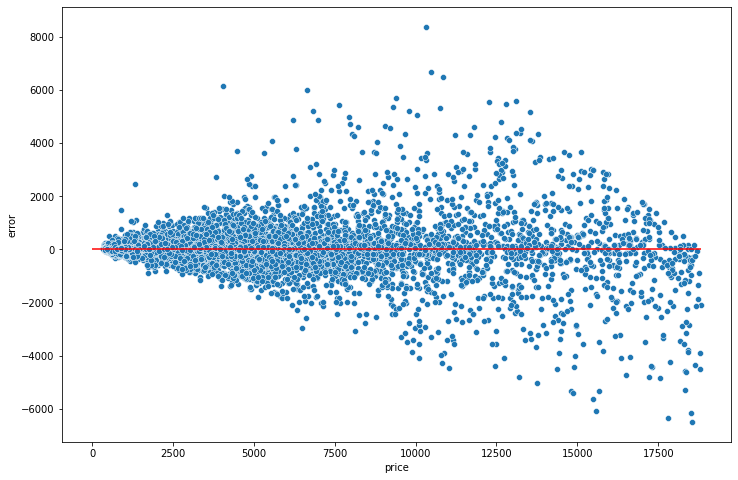

In [ ]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(data=dt_errors_df, x='price', y='error')
plt.hlines(y=0, xmin=0, xmax=max(dt_errors_df['price']), color='red')
plt.show()

The decision tree definitely performs better with cheaper diamonds. But it looks like it is as equally poor at predicting mid price diamons as expensive ones.